In this notebook, we will be attempting to webscrap Intern.sg, a job seeking portal for students.

In [ ]:
import requests ## To get request from the webpage
from bs4 import BeautifulSoup ##P arse the HTML data
import csv ## Save the data in a csv 
import pandas as pd ## Help to transform the data to a suitable format after scraping
import seaborn as sns ## Help to plot visualization
import matplotlib.pyplot as plt

In [ ]:
url = "https://www.internsg.com/jobs/1/#isg-top"

In [ ]:
response = requests.get(url)
response

In [ ]:
soup = BeautifulSoup(response.content, "html.parser")
soup.prettify()

We find that the information that we want are:
Company Name, Role, Commitment Period, Location, Website and Date Posted
There are found under the "ast-col-lg-2","ast-col-lg-1" and "ast-col-lg-3" class tags.

In [ ]:
csv_file = "data.csv"

with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)

print("Empty CSV file created successfully.")

Initializing an empty CSV to store the data.

In [ ]:
location_post_tag = soup.findAll("div", class_=["ast-col-lg-2","ast-col-lg-1"])
location_post_text = [x.text.strip() for x in location_post_tag][2:]

company_role_period_div = soup.findAll("div", class_=["ast-col-lg-3"])
company_role_period_text = [x.text.strip() for x in company_role_period_div][3:]

web_type_div = [div.findAll("span", class_="text-monospace") for div in company_role_period_div]
web_type_text = [x[0].text.strip() for x in web_type_div if x != []]

We will find the respective tags and strip the text to remove any unncessary spacing

In [ ]:
web_type_text

We can see that current the data are stored in a organized list, with each index representing a specific type of information. Let's split them into their respective list (columns)

In [ ]:
location = location_post_text[::2]
post_date = location_post_text[1::2]
company = company_role_period_text[::3]
role = company_role_period_text[1::3]
period = company_role_period_text[2::3]
web = web_type_text[::2]
job_type = web_type_text[1::2]

Now that we have all of the respective columns, we will convert them into a dataframe and save into our csv.

In [ ]:
df = pd.DataFrame({'Company Name': company,
                       'Role': role,
                       'Commitment Period': period,
                      'Location': location,
                       'Job Type': job_type,
                       'Date Posted': post_date,
                       'Website': web})

df.to_csv(csv_file, index=False, header=True)

We have successfully scraped the first page of the website. Let's repeat the rest for subsequent pages.

In [ ]:
for page in range(2, 121):
    url = f"https://www.internsg.com/jobs/{page}/#isg-top"
    response = requests.get(url)
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    ##Obtaining the raw data
    location_post_tag = soup.findAll("div", class_=["ast-col-lg-2","ast-col-lg-1"])
    location_post_text = [x.text.strip() for x in location_post_tag][2:]
    company_role_period_div = soup.findAll("div", class_=["ast-col-lg-3"])
    company_role_period_text = [x.text.strip() for x in company_role_period_div][3:]
    web_type_div = [div.findAll("span", class_="text-monospace") for div in company_role_period_div]
    web_type_text = [x[0].text.strip() for x in web_type_div if x != []]

    ##Converting them to their columns.
    location = location_post_text[::2]
    post_date = location_post_text[1::2]
    company = company_role_period_text[::3]
    role = company_role_period_text[1::3]
    period = company_role_period_text[2::3]
    web = web_type_text[::2]
    job_type = web_type_text[1::2]

    ##Saving data
    df = pd.DataFrame({'Company Name': company,
                       'Role': role,
                       'Commitment Period': period,
                      'Location': location,
                       'Job Type': job_type,
                       'Date Posted': post_date,
                       'Website': web})
    
    df_existing = pd.read_csv(csv_file)
    df_combined = pd.concat([df_existing, df])
    df_combined.to_csv(csv_file, index=False)

    print(f"CSV file saved successfully for page {page}.")

Now let us look at our data

In [ ]:
intern_df = pd.read_csv('data.csv')
intern_df

We see that some of the columns are not very well formatted. I will now clean up the data by removing the `website` from the `company name` and `job type` from `commitment period` Additionally, let's add an additional column to indicate WFH availability.

In [ ]:
intern_df['Company Name'] = intern_df.apply(lambda row: row['Company Name'].split(row['Website'])[0], axis=1)
intern_df['Company Name'] = intern_df.apply(lambda row: row['Company Name'].split(' Pte Ltd')[0], axis=1)    
intern_df['Commitment Period'] = intern_df.apply(lambda row: row['Commitment Period'].split(row['Job Type'])[0], axis=1)
intern_df['Work From Home'] = intern_df.apply(lambda row: True if (row['Location'].find('Work from Home') != -1) else False, axis=1)
intern_df['Location'] = intern_df.apply(lambda row: row['Location'].split('Work from Home')[0], axis=1)

In [ ]:
intern_df['Country'] = intern_df.apply(lambda row: row['Location'].split(',')[-1], axis=1)
intern_df['Location'] = intern_df.apply(lambda row: row['Location'].split(',')[0] if len(row['Location'].split(',')) > 1 else None, axis=1)

In [ ]:
intern_df

In [ ]:
intern_df.info()

Once we have format our data, we can now begin to explore our data

In [ ]:
company_counts = intern_df.groupby('Company Name')['Company Name'].count()
top_10_counts = company_counts.sort_values(ascending=False).head(10)
top_10_counts

In [ ]:
plt.bar(top_10_counts.index, top_10_counts.values, color='darkblue')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.title('Top 10 Companies by Count')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plt.show()

Unsurprisingly, the most number of job posting made was by SnapHunt, a recruitment agency. Now, let's look at what are the popular roles that companies are looking for.

In [ ]:
role_counts = intern_df.groupby('Role')['Role'].count()
top_10_role_counts = role_counts.sort_values(ascending=False).head(10)
top_10_role_counts

In this example, we see that there are special characters used by the job poster, such as emoji. Let's remove these to make the results look cleaner.

In [ ]:
import re

intern_df['Role'] = intern_df.apply(lambda row: re.sub(r'[^\w\s]', '', row[1]).strip(), axis=1)
intern_df

In [ ]:
role_counts = intern_df.groupby('Role')['Role'].count()
top_10_role_counts = role_counts.sort_values(ascending=False).head(10)
top_10_role_counts

In [ ]:
plt.bar(top_10_role_counts.index, top_10_role_counts.values, color='darkred')
plt.xlabel('Role')
plt.ylabel('Count')
plt.title('Top 10 Role by Count')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
plt.show()

It seems that roles such as Marketing Intern, Financial Service Intern, Assistant Project Manager and Events Account Servicing Exectutive Intern Advertising are very popular. However, this may be due to the promoted feature of intern.sg, which promotes certain jobs at a fee.

In [ ]:
wfh_count = intern_df['Work From Home'].mean()
wio_count = 1 - wfh_count
sizes = [wfh_count, wio_count]
labels = ['Work From Home', 'Work In Office']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightgreen','lightpink'])
plt.axis('equal')
plt.title('WFH/WIO Distribution')
plt.show()


In [220]:
filtered_df = intern_df[intern_df['Date Posted'] != 'Closed']
filtered_df['Date Posted'] = pd.to_datetime(filtered_df['Date Posted'] + ' ' + str(2023), format='%d %b %Y')
posting_over_time = filtered_df.groupby("Date Posted")['Date Posted'].count()
posting_over_time

/var/folders/8d/5rvptlnd5j9d3zl2fchct6v00000gn/T/ipykernel_65769/3409146503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date Posted'] = pd.to_datetime(filtered_df['Date Posted'] + ' ' + str(2023), format='%d %b %Y')


Date Posted
2023-04-28     29
2023-04-29      2
2023-04-30      5
2023-05-02     55
2023-05-03     57
2023-05-04     32
2023-05-05     46
2023-05-06      4
2023-05-08     61
2023-05-09     38
2023-05-10     50
2023-05-11     37
2023-05-12     25
2023-05-13     20
2023-05-15     35
2023-05-16     28
2023-05-17     43
2023-05-18     49
2023-05-19     31
2023-05-21     24
2023-05-22     43
2023-05-23     29
2023-05-24     52
2023-05-25     61
2023-05-26     24
2023-05-27      4
2023-05-29     59
2023-05-30     48
2023-05-31     44
2023-06-01     29
2023-06-02     12
2023-06-04     15
2023-06-05     61
2023-06-06     57
2023-06-07     30
2023-06-08     55
2023-06-09     40
2023-06-10      2
2023-06-11      7
2023-06-12     42
2023-06-13     43
2023-06-14    199
2023-06-15     39
2023-06-16     59
2023-06-17     10
2023-06-18      3
2023-06-19     24
2023-06-20     31
2023-06-21     64
2023-06-22    128
2023-06-23     44
2023-06-24     11
2023-06-25      5
2023-06-26     43
2023-06-27     3

(array([19478., 19485., 19492., 19499., 19509., 19516., 19523., 19530.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

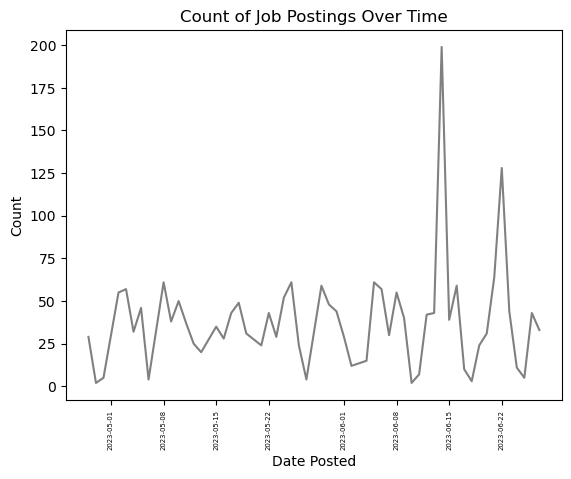

In [266]:
plt.plot(posting_over_time.index, posting_over_time.values, color='grey')
plt.xlabel('Date Posted')
plt.ylabel('Count')
plt.title('Count of Job Postings Over Time')
plt.xticks(rotation=90)
plt.xticks(fontsize=5)


The data look like there are some seasonality to it, with some extreme anomalies. I suspect that the job posting experience a sharp drop when it is a weekend and rises when the work week begins. Let's check if I am correct.

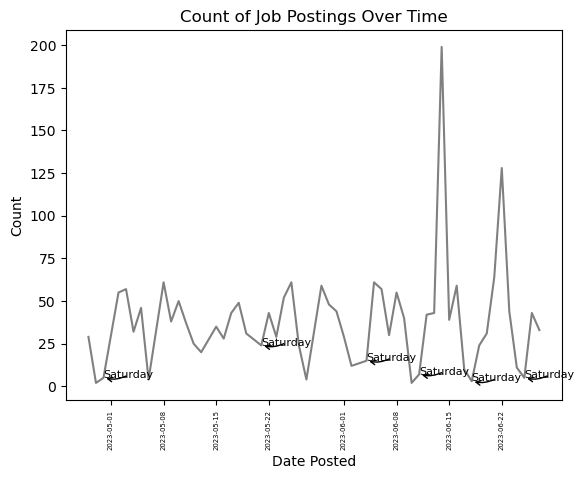

In [265]:
from datetime import datetime

days_of_week = []
for date_string in posting_over_time.index:
    day_of_week = date_string.strftime('%A')
    days_of_week.append(day_of_week)
days_of_week
date_day = list(zip(posting_over_time.index, days_of_week, posting_over_time.values))

plt.plot(posting_over_time.index, posting_over_time.values, color='grey')

for date, day, count in date_day:
    if day == 'Sunday':
        plt.annotate('Saturday',xy=(datetime.strptime(str(date.date()), "%Y-%m-%d"),count), 
            arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=-.2'),
            fontsize=8)

plt.xlabel('Date Posted')
plt.ylabel('Count')
plt.title('Count of Job Postings Over Time')
plt.xticks(rotation=90)
plt.xticks(fontsize=5)
plt.show()


As can be seen with the annotation, job posting experience a dip on Saturday.